## Import Libraries

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify as mc
import numpy as np

from matplotlib.patches import Patch
from matplotlib.colors import Normalize

## Constants

In [4]:
TARGET_ACTUAL = "indeks_pembangunan_manusia"
TARGET_PRED = "prediksi_indeks_pembangunan_manusia"

## Data Acquisition

In [5]:
# Data asli
df_actual = pd.read_csv("Processed Data/processed_data.csv")

# Data prediksi tahun 2022
df_pred = pd.read_csv("Processed Data/prediksi_2022.csv")

# Data polygon kabupaten/kota di Indonesia
gdf = gpd.read_file("Shape Data/LapakGIS_Batas_Kabupaten_2024.shp")

In [6]:
df_actual.head(3)

,kabupaten,tahun,indeks_kemahalan_konstruksi,indeks_pembangunan_manusia,produk_domestik_regional_bruto,persentase_penduduk_miskin,prevalensi_ketidakcukupan_konsumsi_pangan,proporsi_perempuan_melahirkan_anak_pertama_kurang_dari_20_tahun
0,Simeulue,2020,109.99,66.03,2274.36,18.49,11.44,0.291
1,Aceh Singkil,2020,99.72,68.94,2422.61,20.20,7.19,0.283
2,Aceh Selatan,2020,98.07,67.12,5530.75,12.87,8.57,0.287


In [7]:
df_pred.head(3)

,kabupaten,tahun,prediksi_indeks_pembangunan_manusia
0,Simeulue,2022,65.628326
1,Aceh Singkil,2022,63.933918
2,Aceh Selatan,2022,70.096039


In [8]:
gdf.head(3)

,KDPKAB,KDPPUM,WADMKK,WADMPR,METADATA,UPDATED,geometry
0,None,None,None,None,TASWIL1000020230928_DATA_BATAS_KABUPATEN,Lapak GIS - 2024,"MULTIPOLYGON Z (((98.17921 2.09877 -2.35e-5, 9..."
1,None,None,None,Jawa Timur,TASWIL1000020230928_DATA_BATAS_KABUPATEN,Lapak GIS - 2024,"POLYGON Z ((112.87931 -7.5752 -2.35e-5, 112.87..."
2,None,13,None,Sumatera Barat,TASWIL1000020230928_DATA_BATAS_KABUPATEN,Lapak GIS - 2024,"MULTIPOLYGON Z (((100.32955 -1.14545 -2.35e-5,..."


## Formatting

Membuat fungsi bantuan untuk penyamaan format nama kabupaten/kota pada dataset polygon dengan dataset prediksi & aktual

In [9]:
def clean_name(s):
  return (
    s.str.upper()
      .str.replace(" ", "", regex=False)
      .str.replace("KOTA", "", regex=False)
      .str.replace("KABUPATEN", "", regex=False)
      .str.replace("ADM.", "", regex=False)
      .str.replace("KEP.", "", regex=False)
      .str.strip()
  )

Menggunakan fungsi `clean_name` ke kolom kabupaten/kota

In [10]:
df_actual['kabupaten_clean'] = clean_name(df_actual['kabupaten'])
df_pred['kabupaten_clean'] = clean_name(df_pred['kabupaten'])
gdf["WADMKK_clean"] = clean_name(gdf["WADMKK"])

## Uji Merge

In [11]:
# Gabungan SHP + Data asli
test_merged_actual = gdf.merge(
  df_actual,
  how="left",
  left_on="WADMKK_clean",
  right_on="kabupaten_clean"
)

In [12]:
# Filter baris yang hasil merge-nya tidak sama
merged_not_equal = test_merged_actual.loc[
    test_merged_actual["WADMKK_clean"] != test_merged_actual["kabupaten_clean"]
]

# Tampilkan hanya WADMKK_clean yang tidak kosong
mismatch_values = (
    merged_not_equal
    .loc[merged_not_equal["WADMKK_clean"].notna(), "WADMKK_clean"]
)

mismatch_values

109                                      TOBA
167                           PADANGSIDEMPUAN
986                      SUMBAWA/SUMBAWABARAT
1270    MINAHASASELATAN/BOLAANGMONGONDWOTIMUR
1310                                 TOLITOLI
1323                               TOJOUNAUNA
1400                                 MAKASSAR
1470                                 PAHUWATO
1483                               PASANGKAYU
1505                        KEPULAUANTANIMBAR
Name: WADMKK_clean, dtype: object

## Memperbaiki Edge Case Formatting

In [13]:
# Mapping nama kabupaten/kota agar sesuai data aktual/prediksi
gdf['WADMKK'] = gdf['WADMKK'].replace({
  'Toba': 'Toba Samosir / Toba',
  'Kota Padang Sidempuan': 'Padang Sidimpuan',
  'Toli Toli': 'Toli-Toli',
  'Tojo Una Una': 'Tojo Una-Una',
  'Kota Makassar': 'Makasar',
  'Pahuwato': 'Pohuwato',
  'Pasangkayu': 'Mamuju Utara / Pasangkayu',
  'Kepulauan Tanimbar': 'Maluku Tenggara Barat / Kepulauan Tanimbar',
})

# Drop nama kabupaten/kota tanpa pasangan (agar hasil tidak membingungkan)
gdf = gdf[~gdf['WADMKK_clean'].isin([
  "SUMBAWA/SUMBAWABARAT",
  "MINAHASASELATAN/BOLAANGMONGONDWOTIMUR"
  ])]

# Ulangi formatting
gdf = gdf.copy()
gdf["WADMKK_clean"] = clean_name(gdf["WADMKK"])

Uji merge lagi

In [14]:
# Gabungan SHP + Data asli
test_merged_actual = gdf.merge(
  df_actual,
  how="left",
  left_on="WADMKK_clean",
  right_on="kabupaten_clean"
)

# Filter baris yang hasil merge-nya tidak sama
merged_not_equal = test_merged_actual.loc[
    test_merged_actual["WADMKK_clean"] != test_merged_actual["kabupaten_clean"]
]

# Tampilkan hanya WADMKK_clean yang tidak kosong
mismatch_values = (
    merged_not_equal
    .loc[merged_not_equal["WADMKK_clean"].notna(), "WADMKK_clean"]
)

mismatch_values

Series([], Name: WADMKK_clean, dtype: object)

Sudah tidak ada yang tersisa/terlewat merge

## Merge

In [15]:
# Gabungan SHP + Data asli
merged_actual = gdf.merge(
    df_actual,
    how="left",
    left_on="WADMKK_clean",
    right_on="kabupaten_clean"
)

# Gabungan SHP + Data prediksi
merged_pred = gdf.merge(
    df_pred,
    how="left",
    left_on="WADMKK_clean",
    right_on="kabupaten_clean"
)

## Visualisasi Mapping 

In [16]:
merged_actual.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1730 entries, 0 to 1729
Data columns (total 17 columns):
 #   Column                                                           Non-Null Count  Dtype   
---  ------                                                           --------------  -----   
 0   KDPKAB                                                           1724 non-null   object  
 1   KDPPUM                                                           1728 non-null   object  
 2   WADMKK                                                           1719 non-null   object  
 3   WADMPR                                                           1729 non-null   object  
 4   METADATA                                                         1730 non-null   object  
 5   UPDATED                                                          1730 non-null   object  
 6   geometry                                                         1730 non-null   geometry
 7   WADMKK_clean             

In [17]:
def visualize_map_actual(column, cmap, legend_format="{:.2f}"):
    years = [2020, 2021]
    subset = merged_actual[merged_actual["tahun"].isin(years)]
    mean_values = subset.groupby("kabupaten_clean")[column].mean().reset_index()
    geo_unique = merged_actual.drop_duplicates("kabupaten_clean")[["kabupaten_clean", "geometry"]]
    gdf_mean = geo_unique.merge(mean_values, on="kabupaten_clean", how="left")

    _, ax = plt.subplots(figsize=(15, 5))

    gdf_mean.plot(
        column=column,
        cmap=cmap,
        linewidth=0.3,
        edgecolor="black",
        legend=True,
        scheme='FisherJenks',
        legend_kwds={
            'title': f'Kategori',
            'bbox_to_anchor': (1, 1),
            'ncol': 1,
            'fontsize': 9,
            'title_fontsize': 10,
            'fmt': legend_format
        },
        ax=ax
    )
    
    ax.set_axis_off()

    ax.set_title(
        f"Peta Rata-Rata {column.replace('_', ' ').title()} (2020-2021)",
        fontsize=13,
        pad=15
    )

    plt.show()


### Indeks Kemahalan Konstruksi

d:\IPM - Kabupaten Kota-20251203T061053Z-3-001\.venv\Lib\site-packages\geopandas\plotting.py:746: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(


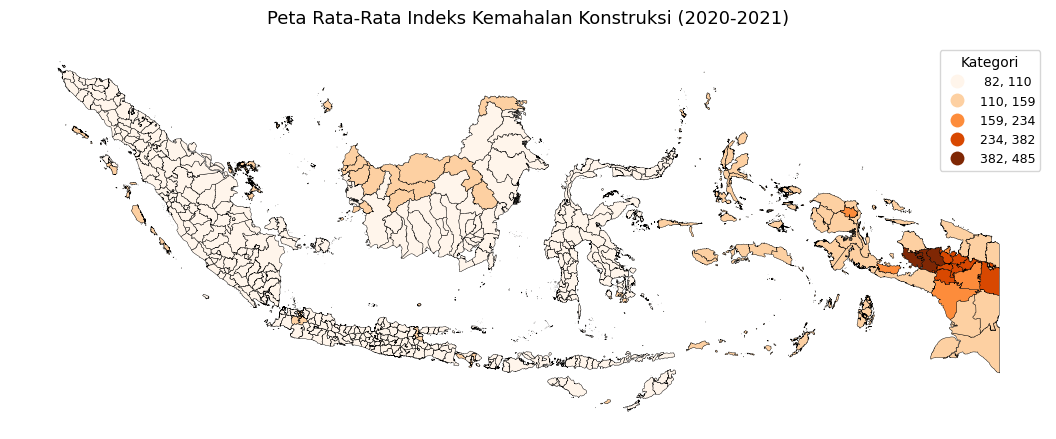

In [18]:
visualize_map_actual("indeks_kemahalan_konstruksi", "Oranges", "{:.0f}")

### Produk Domestik Regional Bruto

d:\IPM - Kabupaten Kota-20251203T061053Z-3-001\.venv\Lib\site-packages\geopandas\plotting.py:746: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(


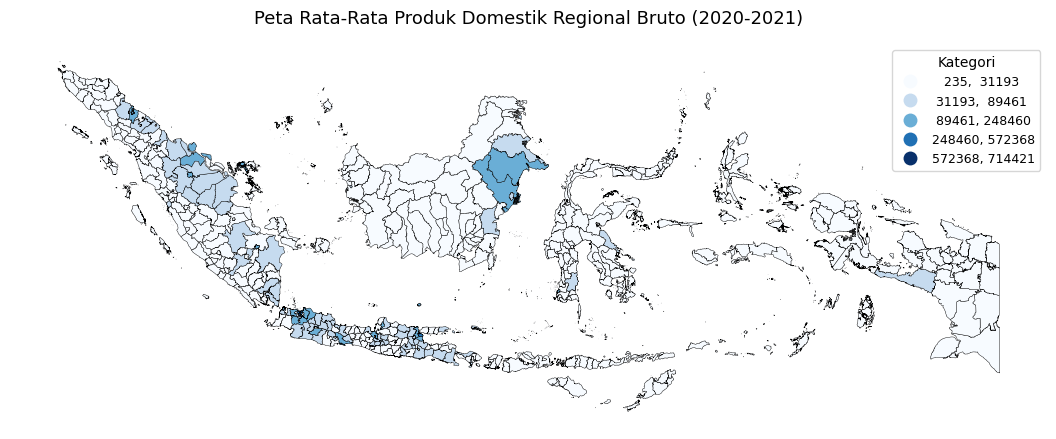

In [19]:
visualize_map_actual("produk_domestik_regional_bruto", "Blues", "{:.0f}")

### Persentase Penduduk Miskin

d:\IPM - Kabupaten Kota-20251203T061053Z-3-001\.venv\Lib\site-packages\geopandas\plotting.py:746: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(


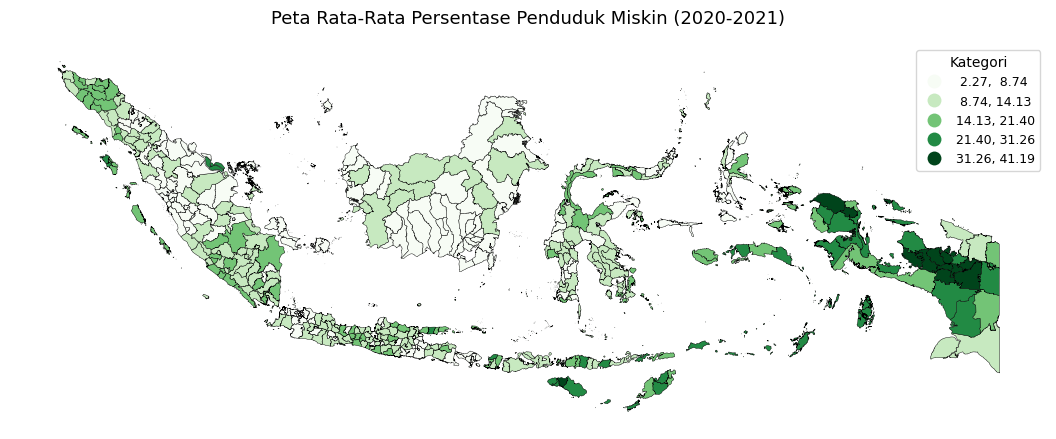

In [20]:
visualize_map_actual("persentase_penduduk_miskin", "Greens")

### Proporsi Perempuan Melahirkan Anak Pertama Kurang dari 20 Tahun

d:\IPM - Kabupaten Kota-20251203T061053Z-3-001\.venv\Lib\site-packages\geopandas\plotting.py:746: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(


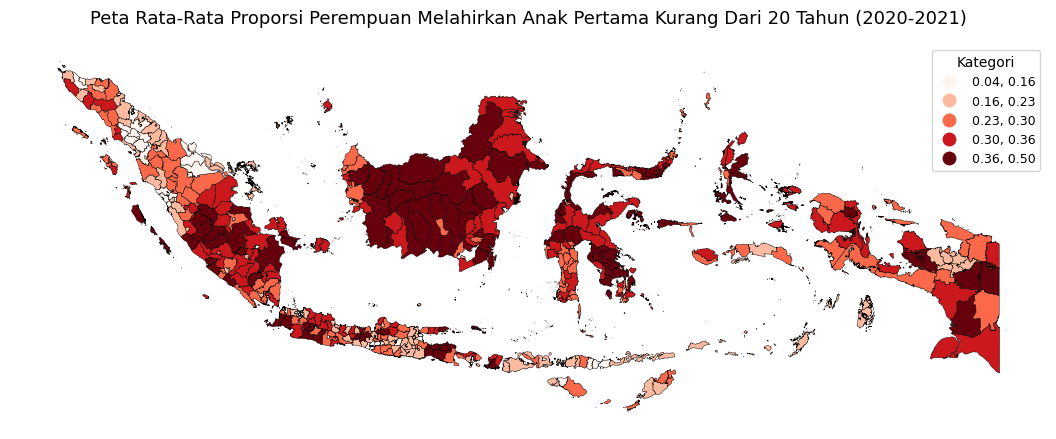

In [21]:
visualize_map_actual("proporsi_perempuan_melahirkan_anak_pertama_kurang_dari_20_tahun", "Reds")

### Indeks Pembangunan Manusia

d:\IPM - Kabupaten Kota-20251203T061053Z-3-001\.venv\Lib\site-packages\geopandas\plotting.py:746: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(


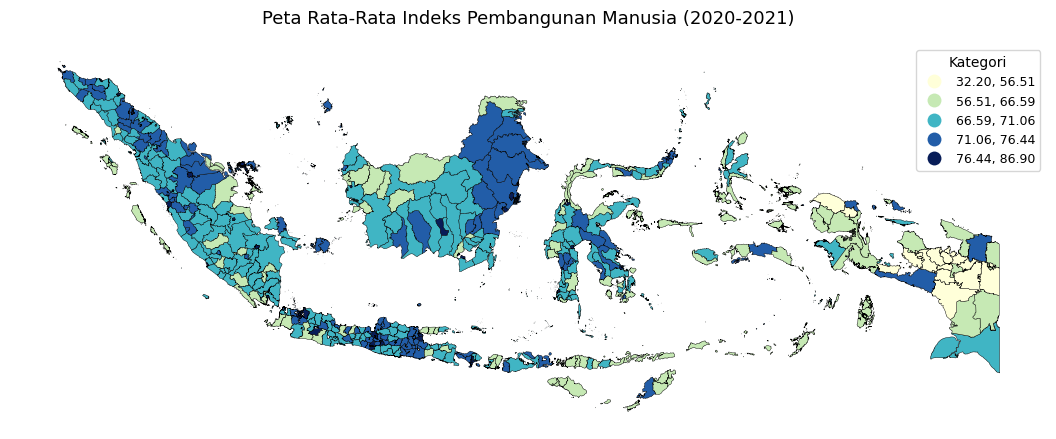

In [22]:
visualize_map_actual(TARGET_ACTUAL, "YlGnBu")

## Visualisasi Mapping 2022

IPM Aktual

d:\IPM - Kabupaten Kota-20251203T061053Z-3-001\.venv\Lib\site-packages\geopandas\plotting.py:746: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(


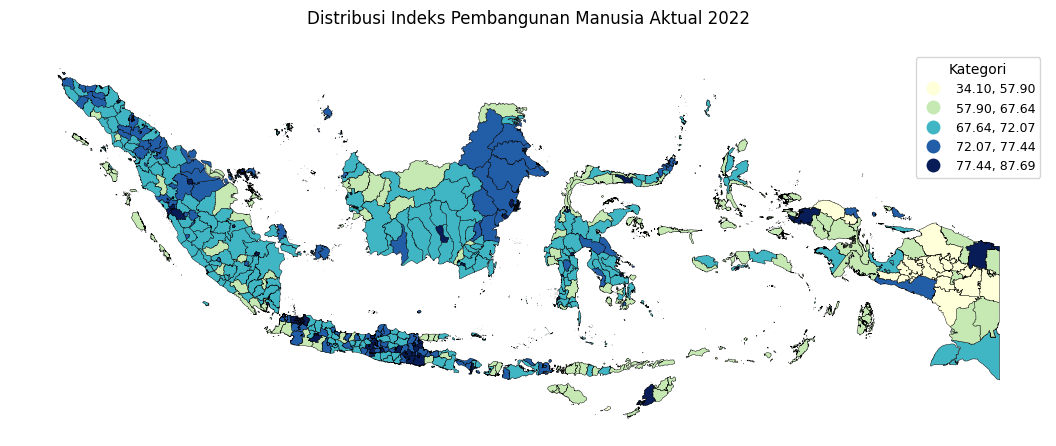

In [23]:
map_df = merged_actual[merged_actual["tahun"] == 2022]

_, ax = plt.subplots(figsize=(15, 5))

map_df.plot(
    column=TARGET_ACTUAL,
    cmap="YlGnBu",
    linewidth=0.3,
    edgecolor="black",
    legend=True,
    scheme='FisherJenks',
    legend_kwds={
        'title': f'Kategori',
        'bbox_to_anchor': (1, 1),
        'ncol': 1,
        'fontsize': 9,
        'title_fontsize': 10,
        'fmt': "{:.2f}"
    },
    ax=ax
)

plt.title(
    f"Distribusi Indeks Pembangunan Manusia Aktual 2022",
    fontsize=12,
    pad=20
)
plt.axis("off")
plt.show()

Prediksi IPM

d:\IPM - Kabupaten Kota-20251203T061053Z-3-001\.venv\Lib\site-packages\geopandas\plotting.py:746: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(


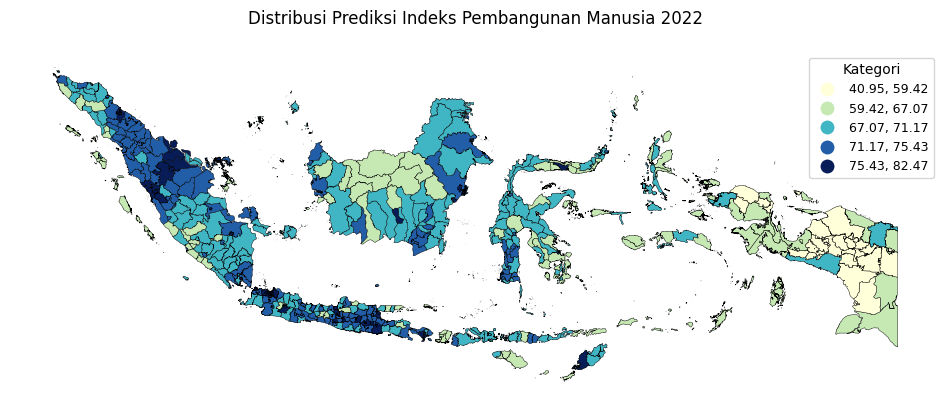

In [24]:
_, ax = plt.subplots(figsize=(12, 5))

merged_pred.plot(
    column=TARGET_PRED,
    cmap="YlGnBu",
    linewidth=0.3,
    edgecolor="black",
    legend=True,
    scheme='FisherJenks',
    legend_kwds={
        'title': f'Kategori',
        'bbox_to_anchor': (1, 1),
        'ncol': 1,
        'fontsize': 9,
        'title_fontsize': 10,
        'fmt': "{:.2f}"
    },
    ax=ax
)

plt.title(
    f"Distribusi Prediksi Indeks Pembangunan Manusia 2022",
    fontsize=12,
    pad=20
)
plt.axis("off")
plt.show()

Side by side

d:\IPM - Kabupaten Kota-20251203T061053Z-3-001\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3699: UserWarning: Numba not installed. Using slow pure python version.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Asus\AppData\Local\Temp\ipykernel_21916\1383256545.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_continuous = plt.cm.get_cmap("YlGnBu", len(breaks))


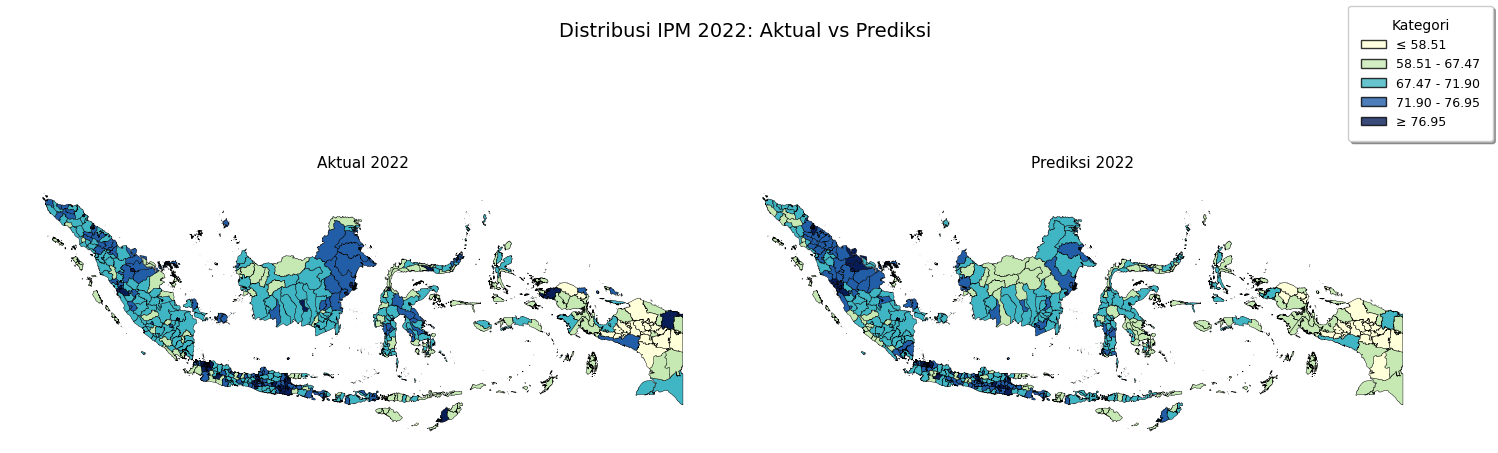

In [25]:
map_actual = merged_actual[merged_actual["tahun"] == 2022]
map_pred = merged_pred

combined_data = pd.concat([
    map_actual[TARGET_ACTUAL].dropna(),
    map_pred[TARGET_PRED].dropna()
])

k_classes = 5
classifier = mc.FisherJenks(combined_data, k=k_classes)
breaks = classifier.bins.tolist()

labels = []
for i in range(len(breaks)):
    if i == 0:
        labels.append(f"≤ {breaks[i]:.2f}")
    elif i == len(breaks) - 1:
        labels.append(f"≥ {breaks[i-1]:.2f}")
    else:
        labels.append(f"{breaks[i-1]:.2f} - {breaks[i]:.2f}")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

map_actual.plot(
    column=TARGET_ACTUAL,
    cmap="YlGnBu",
    linewidth=0.3,
    edgecolor="black",
    scheme='user_defined',
    classification_kwds={'bins': breaks},
    legend=False,
    ax=axes[0]
)
axes[0].set_title("Aktual 2022", fontsize=11, pad=10)
axes[0].axis("off")

map_pred.plot(
    column=TARGET_PRED,
    cmap="YlGnBu",
    linewidth=0.3,
    edgecolor="black",
    scheme='user_defined',
    classification_kwds={'bins': breaks},
    legend=False,
    ax=axes[1]
)
axes[1].set_title("Prediksi 2022", fontsize=11, pad=10)
axes[1].axis("off")

cmap_continuous = plt.cm.get_cmap("YlGnBu", len(breaks))
colors = cmap_continuous(np.linspace(0.1, 0.9, len(breaks)))

legend_elements = []
for i in range(len(breaks)):
    legend_elements.append(Patch(
        facecolor=colors[i],
        edgecolor='black',
        alpha=0.8,
        label=labels[i]
    ))

fig.legend(
    handles=legend_elements,
    title=f'Kategori',
    fontsize=9,
    title_fontsize=10,
    frameon=True,
    fancybox=True,
    shadow=True,
    borderpad=1
)

plt.tight_layout(rect=[0, 0, 0.97, 0.97])

plt.suptitle(
    f"Distribusi IPM 2022: Aktual vs Prediksi", 
    fontsize=14, 
    y=0.97
)

plt.show()